# Accessing data in the flood workflow using DataCatalog

The COMPASS compound flood hazard modelling workflow makes use of the HydroMT DataCatalog functionality for reading input data. Configuration files for model setup contain keywords that refer to the entries in the DataCatalog. The DataCatalog entries are used to instruct HydroMT on how to access the data, by specifying among other parameters:
- Path to the dataset.
- Type of the dataset (e.g. raster, vector, geodataset, geodataframe).
- Options for renaming and adjusting variables.
- Instructions on combining data in case of mutiple data files.
- Metadata, including license information, versioning and references.

When adding new data (or changing the location of the data) it is necessary to edit the data catalog file to ensure the data can be loaded correctly. The data catalogs used by the workflow are found in [this folder](https://github.com/HORIZON-COMPASS/compound-flooding-tropical-cyclones/tree/main/Workflows/03_data_catalogs). 
Please note:
- not all data sources that is listed in the data catalog files are necessary to run the workflow. The user only needs to edit the specific entries that are accessed by the models (see overview below).
- currently two copies of the data catalog are supplied - for Windows and Linux systems. The difference between these files is in the root directory name specified under `meta: root:` at the start of the data catalog file. In a future update these catalogs will be unified.

For more information on DataCatalog functionality please refer to:  
[HydroMT DataCatalog documentation with examples](https://deltares.github.io/hydromt/v0.5.0/user_guide/data_main.html)

## Data overview for the compound flood hazard modelling framework 

The  models involved in the compound flood modelling workflow require access to various datasets, most of which can be easily obtained from open sources. In order for the workflow to make use of these datasets, they need to be stored locally and have a corresponding entry in the data catalog. Below an overview of the datasets used in the default configuration of the workflow is given per model, including their handles as used in the data catalogs.

Please note that in case alternative datasets are preferred by the user, they need to adjust the configuration of the workflow (i.e. in a [snakemake configuration file](https://github.com/HORIZON-COMPASS/compound-flooding-tropical-cyclones/tree/main/Workflows/01_config_snakemake)). Advanced users can also adjust the default [configurations of the models](https://github.com/HORIZON-COMPASS/compound-flooding-tropical-cyclones/tree/main/Workflows/05_config_models).

### Coastal hydrodynamics model
Hydrodynamic model **Delft3D-FM** requires the following data:
- Bathymetry: General Bathymetric Chart of the Oceans, GEBCO_2024 (`gebco`)
- Meteorological data - MSL pressure and wind speeds at 10m height: ERA5 reanalysis (`era5_hourly`)

Additionally:
- Shapefile containing points where the resulting water levels will be saved (at the boundary of the flood model): this file is generated by the user, see [instructions](https://github.com/HORIZON-COMPASS/compound-flooding-tropical-cyclones/blob/main/docs/notebooks/Creating_coastal_mask_and_DFM_output_locations_files.md) for setting up a model for a new region (`coastal_coupling_DFM_obs_points_{region}` in `datacatalog_SFINCS_coastal_coupling.yml`)

The hydrodynamic model also makes use of a tidal dataset in order to prescribe tidal boundary conditions, however this dataset is accessed via OPeNDAP instead of the DataCatalog.



### Hydrological model
The setup of the hydrological model **wflow** requires the following data:

Static datasets:
- Elevation and hydrography data: MERIT-Hydro (`merit_hydro` and `merit_hydro_index`)
- River geometry: global dataset of bankfull river width from [Lin et al. 2019](https://zenodo.org/records/3552776#.YVbOrppByUk) (`rivers_lin2019_v1`)
- Geometry of water bodies globally: reservoirs, lakes, glaciers (`hydro_reservoirs`, `hydro_lakes`, `rgi`)
- Global vegetation cover (`modis_lai`)
- Soil data (`soilgrids` and `ksathorfrac_global`)
- Land use (`vito`)

Forcing:
- Precipitation data: ERA5 reanalysis (`era5_hourly`)

### Flood model
Flood model **SFINCS** requires the following data:

Static datasets:
- Elevation and hydrography: MERIT-Hydro (`merit_hydro`)
- Global coastlines and oceans (`ocean_shape` and `osm_coastlines`)
- Land use (`vito` and `vito_mapping`)
- Soil infiltration (`gcn250`)

Additionally:
- Coastal mask: this file is generated by the user, see [instructions](https://github.com/HORIZON-COMPASS/compound-flooding-tropical-cyclones/blob/main/docs/notebooks/Creating_coastal_mask_and_DFM_output_locations_files.md) for setting up a model for a new region (`coastal_coupling_msk_{region}` in `datacatalog_SFINCS_coastal_coupling.yml`)


Forcing:
- Wind speeds: ERA5 reanalysis (`era5_hourly`)
- Precipitation: ERA5 reanalysis (`era5_hourly`)
- Coastal water levels and river discharges at the boundaries: these timeseries are generated within the workflow.

Optional:
- _(optional as alternative to Delft3D-FM)_ timeseries dataset of coastal water levels: GTSM-ERA5 global dataset (`gtsm_codec_reanalysis_hourly_v2`)
- _(optional as alternative to wflow)_ timeseries of river discharges at the river inflow points (**still to be implemented**)




## Examples of accessing data using the DataCatalog

In order to execute the example below, you need to install hydromt (v0.10.0) package in your python environment (or use pixi environment with hydromt included, e.g. `compass-wflow` environment).

In [ ]:
# import libraries
from os.path import join
import hydromt
from hydromt.log import setuplog

logger = setuplog("read raster data", log_level=10)

2025-04-04 12:44:46,295 - read raster data - log - INFO - HydroMT version: 0.10.0


The example provided below is made for Windows and links to the main data catalog of the workflow available via GitHub. To run it on Linux, change the data catalog path to the catalog made for Linux.

In [ ]:
# path to DataCatalog file 
path_datacat = join("..\..\Workflows", "03_data_catalogs", "datacatalog_general.yml")

In [11]:
# Initialize data catalog
data_cat = hydromt.DataCatalog(data_libs=path_datacat, logger=logger)

2025-04-04 12:02:02,919 - read raster data - data_catalog - INFO - Parsing data catalog from ..\..\Workflows\03_data_catalogs\datacatalog_general.yml


Once the data catalog has been initialized, we can check the content of each entry by using the corresponding dataset handle, for example `era5_hourly`:

In [13]:
# inspect data catalog
data_cat['era5_hourly']

crs: 4326
data_type: RasterDataset
driver: netcdf
driver_kwargs:
  chunks:
    latitude: 125
    longitude: 120
    time: 50
  combine: by_coords
  decode_times: true
  parallel: true
meta:
  category: meteo
  notes: Extracted from Copernicus Climate Data Store
  paper_doi: 10.1002/qj.3803
  paper_ref: Hersbach et al. (2019)
  source_license: https://cds.climate.copernicus.eu/cdsapp/#!/terms/licence-to-use-copernicus-products
  source_url: https://doi.org/10.24381/cds.adbb2d47
  source_version: ERA5 hourly data on single levels from 1940 to present
path: p:\wflow_global\hydromt\meteo\era5\{variable}\era5_{variable}_{year}*_hourly.nc
rename:
  d2m: temp_dew
  msl: press_msl
  ssrd: kin
  t2m: temp
  tisr: kout
  tp: precip
  u10: wind10_u
  v10: wind10_v
unit_add:
  temp: -273.15
  temp_dew: -273.15
unit_mult:
  kin: 0.000277778
  kout: 0.000277778
  precip: 1000
  press_msl: 0.01
  ssr: 0.000277778

Below we will access several datasets and inspect their content for a specific geographical area, which is defined using a bounding box. To get these coordinates easily, you can use the [BoundingBox tool](https://boundingbox.klokantech.com/).

In [59]:
bbox = [-3.5, 50.9, -2.5, 51.4] # [lon_min, lat_min, lon_max, lat_max]

### Reading raster data - elevation

Raster datasets can be access using the `get_rasterdataset` method.

In [54]:
ds_dtm = data_cat.get_rasterdataset("merit_hydro", bbox=bbox)

2025-04-04 14:28:26,000 - read raster data - rasterdataset - INFO - Reading merit_hydro raster data from p:\wflow_global\hydromt\topography\merit_hydro\*.vrt
2025-04-04 14:28:30,780 - read raster data - rasterdataset - DEBUG - Clip to [-3.500, 50.900, -2.500, 51.400] (epsg:4326))


We can plot the elevation data to inspect its contents:

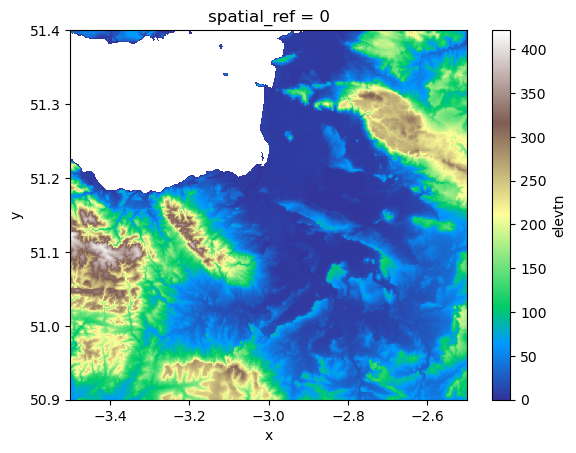

In [ ]:
ds_dtm["elevtn"].raster.mask_nodata().plot(cmap="terrain")

### Reading raster data - meteorology

Meteorological data is usually provided as a gridded raster (e.g. gridded NetCDF file), which can also be read using the `get_rasterdataset` method.

In [45]:
ds_era5 = data_cat.get_rasterdataset('era5_hourly', variables=['precip'], time_tuple=('15-12-2013','15-01-2014'), bbox=bbox, buffer=2) 

2025-04-04 13:13:56,987 - read raster data - rasterdataset - INFO - Reading era5_hourly netcdf data from p:\wflow_global\hydromt\meteo\era5\{variable}\era5_{variable}_{year}*_hourly.nc
2025-04-04 13:13:57,204 - read raster data - rasterdataset - DEBUG - Slicing time dim ('15-12-2013', '15-01-2014')
2025-04-04 13:13:57,301 - read raster data - rasterdataset - DEBUG - Clip to [-3.500, 50.900, -2.500, 51.400] (epsg:4326))
2025-04-04 13:13:57,308 - read raster data - rasterdataset - DEBUG - Convert units for 1 variables.


We can plot the ERA5 data to check spatial resolution and values.

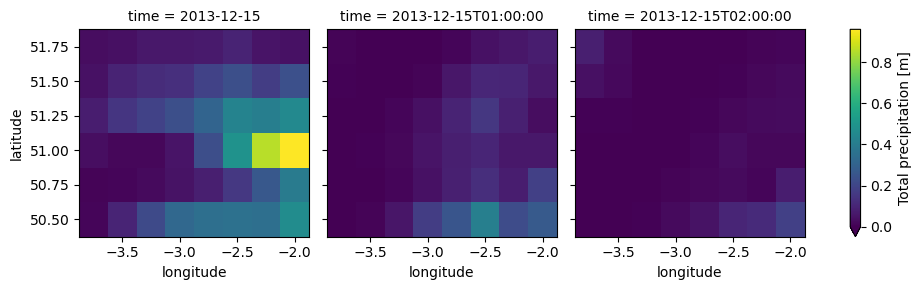

In [51]:
ds_era5.isel(time=slice(0,3)).plot(col='time', vmin=0)

### Reading NetCDF point data - coastal water levels

Some datasets contain timeseries data that is not on a regular grid. An example of this is the database of coastal water levels from [GTSM-ERA5](https://cds.climate.copernicus.eu/datasets/sis-water-level-change-timeseries-cmip6). This type of dataset can be accessed using the `get_geodataset` method:

In [52]:
ds_gtsm = data_cat.get_geodataset('gtsm_codec_reanalysis_hourly_v2', variables=["waterlevel"], time_tuple=('15-12-2013','15-01-2014'), bbox=bbox)

We can plot this data for one of the points by indexing the data on the first item:

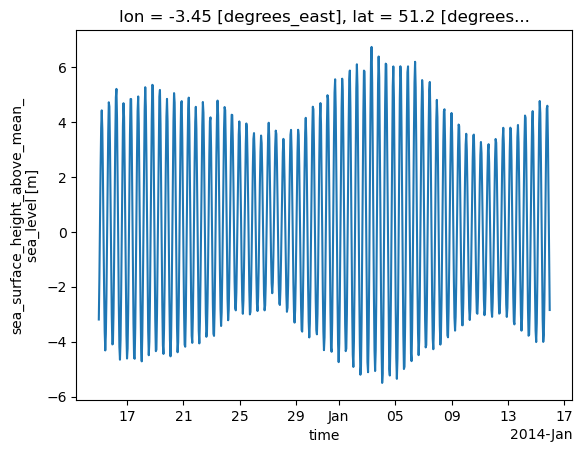

In [61]:
ds_gtsm.isel(index=0).plot()

### Reading vector data - geometry

Vector data such as points and polygons can be read using the `get_geodataframe` method. For example we can retrieve the coastlines dataset from the OpenStreetMap:

In [56]:
ds_osm = data_cat.get_geodataframe('osm_coastlines', bbox=bbox)

2025-04-04 14:33:19,662 - read raster data - geodataframe - INFO - Reading osm_coastlines vector data from p:\wflow_global\hydromt\geography\osm\osm_coastlines-db.fgb
2025-04-04 14:33:21,397 - read raster data - geodataframe - DEBUG - Clip intersects [-3.500, 50.900, -2.500, 51.400] (EPSG:4326)


In [ ]:
# Inspect contents of the file - geopandas dataframe
ds_osm.head()

,geometry
0,"MULTIPOLYGON (((-3.0008 51.2318, -3.0008 51.24..."
1,"MULTIPOLYGON (((-4.0008 51.21846, -4.0008 51.5..."
2,"MULTIPOLYGON (((-3.0008 51.32233, -3.0008 51.5..."


<Axes: >

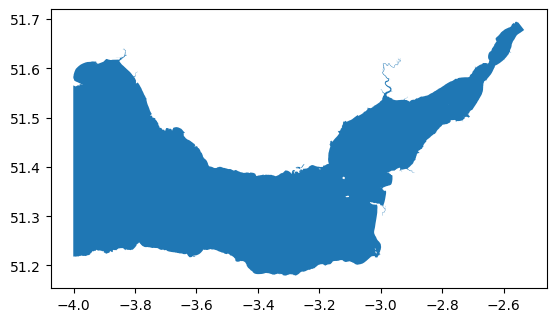

In [62]:
# Plot the data
ds_osm.plot()

When adding new datasets to the DataCatalog, it is recommended to first test whether they can be accessed effectively by following examples presented above. 

*Author: n-aleksandrova*